In [4]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from tensorflow import keras
from keras.models import Sequential
from keras import Input
from keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.callbacks import EarlyStopping

from lightgbm import LGBMRegressor
import random
import xgboost as xgb

In [2]:
curr_dir = os.getcwd()
curr_dir

'C:\\weather\\uv_new'

In [3]:
forders_tr = os.listdir(curr_dir+"\\data\\"+"\\outlier_train_val")
forders_tr

['2001_uv_nooutlier.csv',
 '2002_uv_nooutlier.csv',
 '2003_uv_nooutlier.csv',
 '2004_uv_nooutlier.csv',
 '2005_uv_nooutlier.csv',
 '2006_uv_nooutlier.csv',
 '2007_uv_nooutlier.csv',
 '2008_uv_nooutlier.csv',
 '2009_uv_nooutlier.csv',
 '2010_uv_nooutlier.csv',
 '2011_uv_nooutlier.csv',
 '2012_uv_nooutlier.csv',
 '2101_uv_nooutlier.csv',
 '2102_uv_nooutlier.csv',
 '2103_uv_nooutlier.csv',
 '2104_uv_nooutlier.csv',
 '2105_uv_nooutlier.csv',
 '2106_uv_nooutlier.csv',
 '2107_uv_nooutlier.csv',
 '2108_uv_nooutlier.csv',
 '2109_uv_nooutlier.csv',
 '2110_uv_nooutlier.csv',
 '2111_uv_nooutlier.csv',
 '2112_uv_nooutlier.csv']

In [4]:
summer_tr = forders_tr[4:10] + forders_tr[12+4:12+10-3]
summer_tr

summer_val = forders_tr[12+10-3:12+10]
summer_val

['2108_uv_nooutlier.csv', '2109_uv_nooutlier.csv', '2110_uv_nooutlier.csv']

In [5]:
train = pd.DataFrame()

for files in summer_tr:
    df= pd.read_csv(os.path.join(curr_dir+"\\data\\"+"\\outlier_train_val\\")+files)
    train = pd.concat([train, df])
    
train.drop('idx', axis=1, inplace=True)
train

,yyyymmdd,hhnn,stn,lon,lat,uv,band1,band2,band3,band4,...,band12,band13,band14,band15,band16,solarza,sateza,esr,height,landtype
0,20200501,0,13,126.16000,33.30000,0.0,0.00000,-0.00057,-0.00030,0.00165,...,252.91737,277.63245,277.03649,275.67037,262.71147,130.35092,38.96359,-6.11462,71.00,0
1,20200501,0,105,128.89098,37.75147,0.0,-0.00057,-0.00057,-0.00060,-0.00090,...,256.69212,286.82011,287.23821,285.51819,269.40510,126.43187,43.95463,-5.60867,26.04,3
2,20200501,0,108,126.96500,37.57100,0.0,0.00000,0.00000,0.00000,0.00090,...,253.85590,281.28558,281.42512,280.03692,266.81080,126.31564,43.77999,-5.59822,85.50,3
3,20200501,0,112,126.62490,37.47772,0.0,0.00000,0.00000,0.00089,0.00030,...,254.78101,283.03827,283.39275,282.06360,268.05385,126.36437,43.67046,-5.60546,68.99,3
4,20200501,0,115,130.89864,37.48129,0.0,0.00000,0.00000,0.00030,0.00075,...,251.68704,277.82840,278.25056,275.71853,262.56565,126.91833,43.74521,-5.66707,222.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65607,20210731,2350,146,127.11900,35.84080,0.1,0.00000,-0.00057,0.00030,-0.00060,...,264.53165,291.90287,290.09587,285.48855,270.82702,124.36364,41.81018,-4.72602,62.90,3
65608,20210731,2350,152,129.33472,35.58250,0.0,0.00000,0.00000,0.00000,-0.00030,...,262.88449,288.27382,286.67481,282.45891,269.23268,125.09137,41.52495,-4.87156,82.00,2
65609,20210731,2350,156,126.89158,35.17294,0.0,-0.00057,0.00000,0.00000,0.00015,...,262.57588,287.50208,284.96722,280.05240,267.56515,124.95628,41.04849,-4.79509,72.38,3
65610,20210731,2350,159,129.03203,35.10468,0.0,0.00000,0.00000,-0.00119,0.00000,...,262.22936,287.43410,286.66069,283.63739,270.60537,125.49764,40.96396,-4.91507,69.56,3


In [6]:
ratio=[]
num = []
for i in range(len(train.columns)):
    ratio.append(len(train[train[train.columns[i]] == -999.0])/len(train))
    num.append(len(train[train[train.columns[i]] == -999.0]))
ratio

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [7]:
val = pd.DataFrame()

for files in summer_val:
    df= pd.read_csv(os.path.join(curr_dir+"\\data\\"+"\\outlier_train_val\\")+files)
    val = pd.concat([val, df])
    
val.drop('idx', axis=1, inplace=True)
val

,yyyymmdd,hhnn,stn,lon,lat,uv,band1,band2,band3,band4,...,band12,band13,band14,band15,band16,solarza,sateza,esr,height,landtype
0,20210801,0,13,126.16000,33.30000,0.0,0.00000,-0.00057,0.00089,-0.00015,...,264.44311,290.55389,288.92546,284.67080,270.70772,127.16116,38.96359,-5.60122,71.00,0
1,20210801,0,105,128.89098,37.75147,0.0,-0.00057,-0.00057,0.00000,-0.00015,...,259.14507,283.10942,282.76528,280.43877,268.61000,123.36327,43.95463,-5.09260,26.04,3
2,20210801,0,108,126.96500,37.57100,0.0,0.00000,0.00057,-0.00119,0.00120,...,252.93837,273.65182,270.18990,267.15459,258.99048,123.18739,43.77999,-5.07447,85.50,3
3,20210801,0,112,126.62490,37.47772,0.0,0.00000,0.00000,-0.00030,-0.00060,...,250.27920,268.14394,268.04466,266.56403,259.34748,123.22507,43.67046,-5.08058,68.99,3
4,20210801,0,115,130.89864,37.48129,0.0,0.00000,0.00000,0.00000,-0.00015,...,263.38986,289.67998,288.05013,284.04277,269.26719,123.91259,43.74521,-5.16058,222.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62893,20211031,2350,146,127.11900,35.84080,0.1,0.00000,-0.00057,0.00030,-0.00015,...,243.98668,261.95199,261.21896,259.29863,250.50021,157.14313,41.81018,-8.56636,62.90,3
62894,20211031,2350,152,129.33472,35.58250,0.0,0.00000,0.00000,-0.00089,0.00120,...,255.89419,281.48837,281.57322,280.00595,265.73255,157.99342,41.52495,-8.67521,82.00,2
62895,20211031,2350,156,126.89158,35.17294,0.0,0.00057,0.00000,0.00000,0.00015,...,246.57815,265.43902,264.76641,262.60697,252.65714,157.69250,41.04849,-8.59148,72.38,3
62896,20211031,2350,159,129.03203,35.10468,0.0,0.00057,0.00000,-0.00179,-0.00060,...,257.75436,284.11394,283.85736,280.96228,265.34129,158.37811,40.96396,-8.68840,69.56,3


In [8]:
ratio=[]
num = []
for i in range(len(val.columns)):
    ratio.append(len(val[val[val.columns[i]] == -999.0])/len(val))
    num.append(len(val[val[val.columns[i]] == -999.0]))
ratio

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [23]:
forders_te = os.listdir(curr_dir+"\\data\\"+"\\outlier_test")
forders_te

['202206_uv_noOutlier.csv']

In [24]:
# forders_te = os.listdir(curr_dir+"\\data\\"+"\\test")
# forders_te

df = pd.read_csv(os.path.join(curr_dir+"\\data\\"+"\\outlier_test\\")+forders_te[0])
# d = list(df.columns)
# for j in range(1,len(d)):
#     d[j] = d[j].replace("202206_uv.", "")
# df.columns = d
# df.drop('Unnamed: 0', axis=1, inplace=True)
test = df
test.describe()
test

,Unnamed: 0,yyyymmdd,hhnn,stn,lon,lat,uv,band1,band2,band3,...,band12,band13,band14,band15,band16,solarza,sateza,esr,height,landtype
0,0,20220601,0,13,126.16000,33.30000,0,0.00000,0.00000,-0.00060,...,241.07130,251.49092,250.11913,248.78686,243.12601,123.72706,38.96359,-5.16304,71.00,0
1,1,20220601,0,105,128.89098,37.75147,0,-0.00057,-0.00057,0.00000,...,244.35010,262.71227,261.14580,257.52658,246.95577,119.74915,43.95463,-4.61100,26.04,3
2,2,20220601,0,108,126.96500,37.57100,0,0.00000,-0.00057,-0.00030,...,249.24111,271.81756,270.25616,266.99858,254.94651,119.65871,43.77999,-4.60329,85.50,3
3,3,20220601,0,112,126.62490,37.47772,0,0.00000,0.00000,0.00060,...,249.94977,273.52547,272.33661,269.12853,256.15036,119.71313,43.67046,-4.61180,68.99,3
4,4,20220601,0,115,130.89864,37.48129,0,0.00000,0.00000,0.00089,...,239.88321,253.29031,251.46606,249.01625,240.92761,120.21661,43.74521,-4.67107,222.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51850,51850,20220625,0,146,127.11900,35.84080,0,0.00000,-0.00057,-0.00089,...,258.49191,286.87485,287.19605,285.48855,271.35400,119.84431,41.81018,-4.59718,62.90,3
51851,51851,20220625,0,152,129.33472,35.58250,0,-0.00057,0.00000,-0.00030,...,263.99872,293.32422,293.51096,291.15861,274.60342,120.42121,41.52495,-4.67124,82.00,2
51852,51852,20220625,0,156,126.89158,35.17294,0,0.00000,0.00000,0.00089,...,261.53112,290.14436,290.23278,288.05655,273.15633,120.46896,41.04849,-4.68457,72.38,3
51853,51853,20220625,0,159,129.03203,35.10468,0,0.00000,0.00057,0.00030,...,260.95627,287.80066,287.63090,285.01340,270.36623,120.85844,40.96396,-4.73249,69.56,3


In [25]:
train.columns

Index(['yyyymmdd', 'hhnn', 'stn', 'lon', 'lat', 'uv', 'band1', 'band2',
       'band3', 'band4', 'band5', 'band6', 'band7', 'band8', 'band9', 'band10',
       'band11', 'band12', 'band13', 'band14', 'band15', 'band16', 'solarza',
       'sateza', 'esr', 'height', 'landtype'],
      dtype='object')

In [26]:
test.columns

Index(['Unnamed: 0', 'yyyymmdd', 'hhnn', 'stn', 'lon', 'lat', 'uv', 'band1',
       'band2', 'band3', 'band4', 'band5', 'band6', 'band7', 'band8', 'band9',
       'band10', 'band11', 'band12', 'band13', 'band14', 'band15', 'band16',
       'solarza', 'sateza', 'esr', 'height', 'landtype'],
      dtype='object')

In [21]:
# test = test.rename(columns={'SolarZA':'solarza', 'ESR':'esr'})
# test.columns

Index(['yyyymmdd', 'hhnn', 'stn', 'lon', 'lat', 'uv', 'band1', 'band2',
       'band3', 'band4', 'band5', 'band6', 'band7', 'band8', 'band9', 'band10',
       'band11', 'band12', 'band13', 'band14', 'band15', 'band16', 'solarza',
       'sateza', 'esr', 'height', 'landtype'],
      dtype='object')

In [22]:
# test.to_csv('202206_uv_noOutlier.csv')

In [12]:
ratio=[]
num = []
for i in range(len(test.columns)):
    ratio.append(len(test[test[test.columns[i]] == -999.0])/len(test))
    num.append(len(test[test[test.columns[i]] == -999.0]))
ratio

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

<AxesSubplot:>

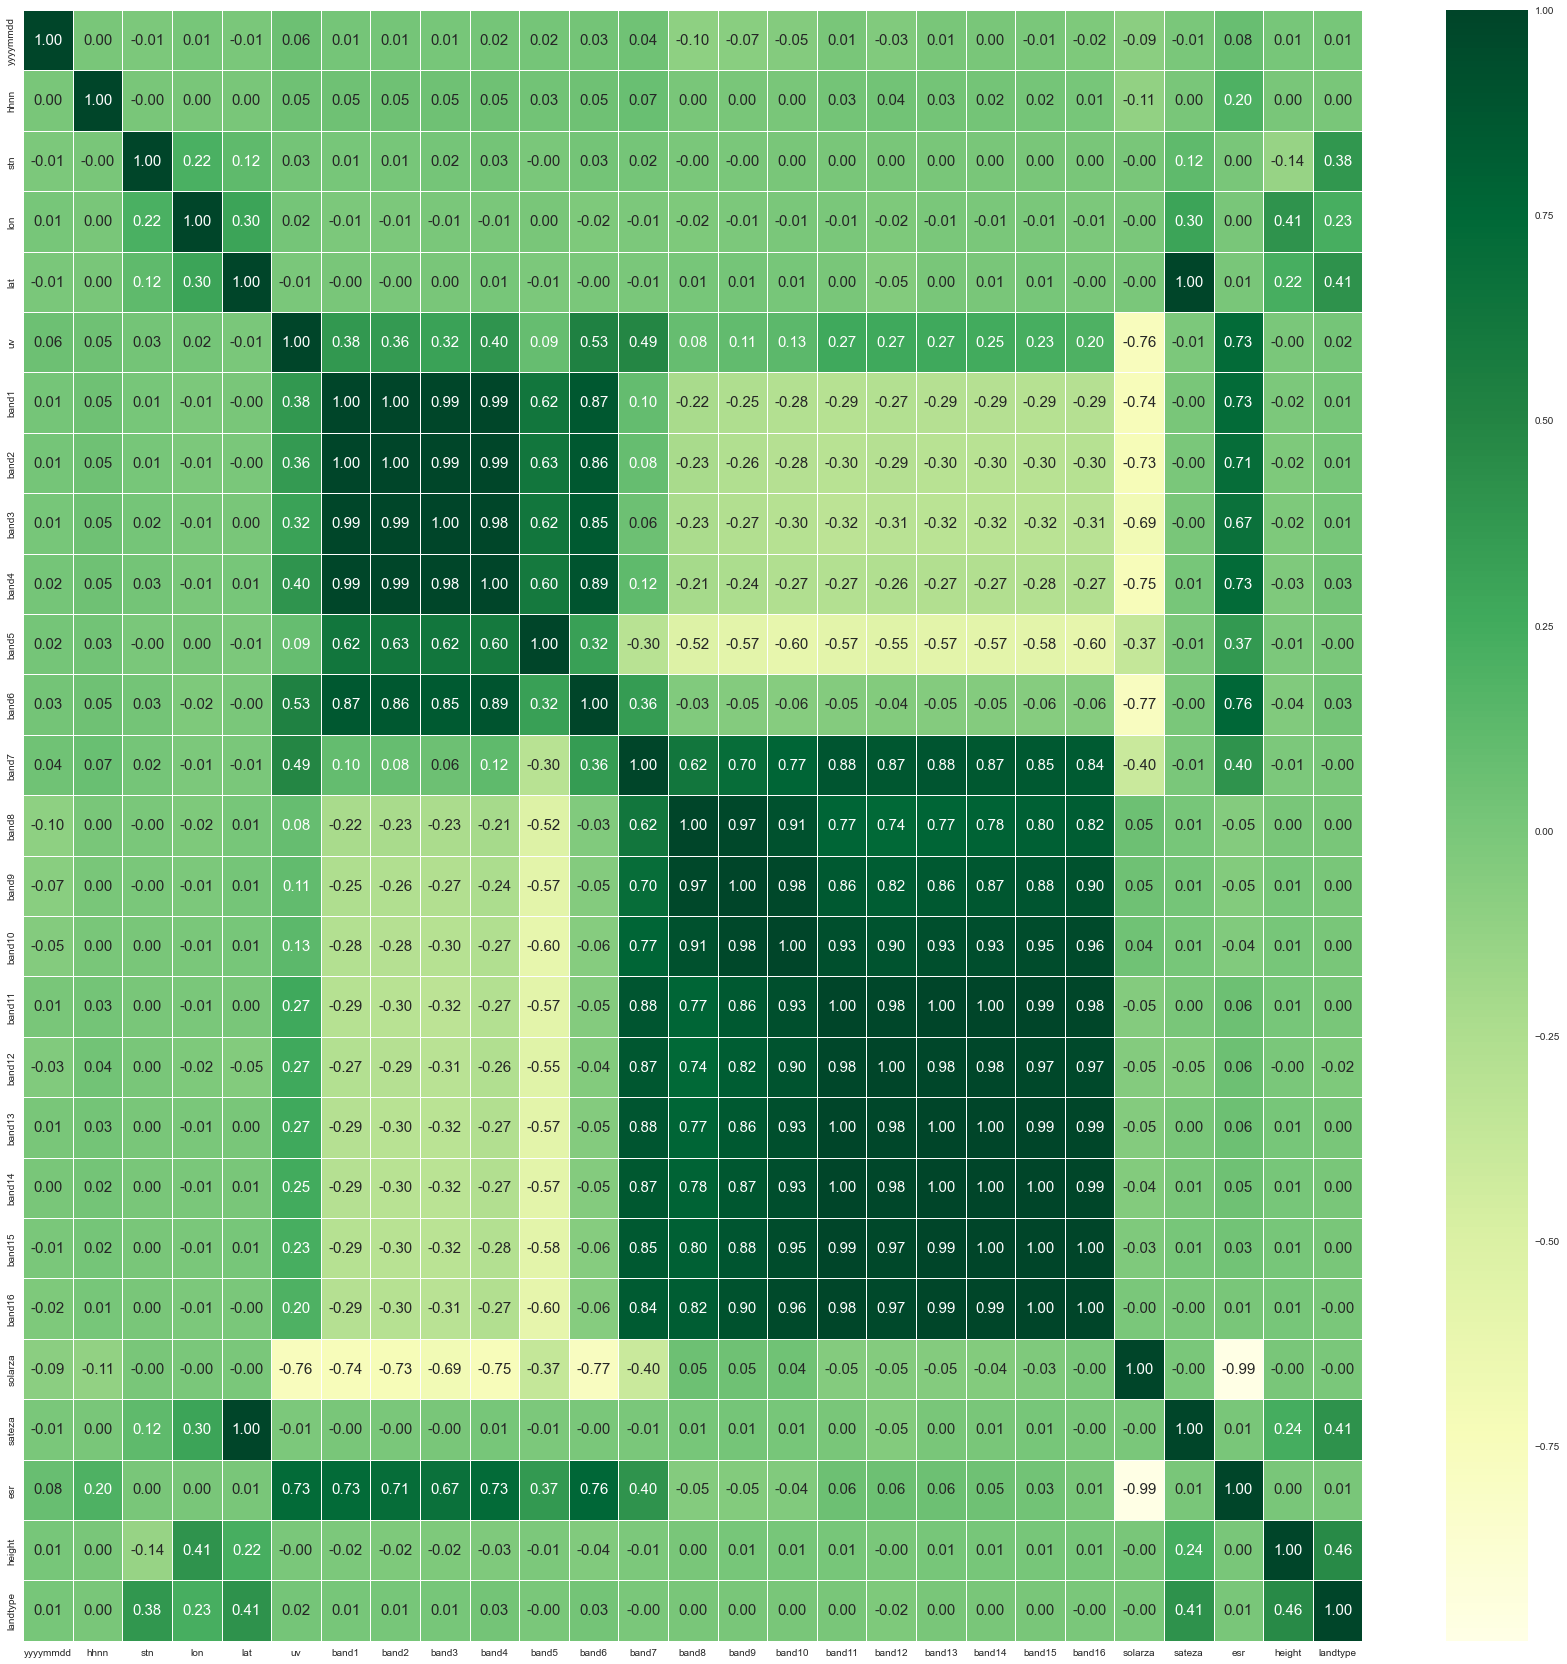

In [16]:
plt.figure(figsize=(30,30))
plt.style.use('seaborn')
sns.heatmap(data = train.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='YlGn', annot_kws={"size": 15})
# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)
# plt.tight_layout()              # 이미지 안 잘리게 저장.
# plt.savefig('corr_34_44.png')

# 'band1,'band2','band3','band4','band6','band7','solarza','esr','band11','band12','band13','band14','band15','band16'

# Model_by_xgb_feature_importance

In [38]:
# def model_train(curr_dir):
 
#     path_train = os.path.join(curr_dir+"\\data_rota\\"+"\\train")
#     path_test = os.path.join(curr_dir+"\\data_rota\\"+"\\test")
    
#     folders_tr = os.listdir(path_train)
#     folders_test = os.listdir(path_test)
    
#     train = pd.DataFrame()
#     for files in folders_tr:
#         df= pd.read_csv(os.path.join(curr_dir+"\\data_rota\\"+"\\train\\")+files)
#         train = pd.concat([train, df])            
              
    
#     test = pd.DataFrame()
#     for files in folders_test:
#         df= pd.read_csv(os.path.join(curr_dir+"\\data_rota\\"+"\\test\\")+files)
#         test = pd.concat([test, df])   


#     X_train = train[['band1','band2', 'band3', 'band4','band6', 'band7','band11', 'band12', \
#                      'band13', 'band14', 'band15', 'band16','solarza','esr']]
#     X_val = val[['band1','band2', 'band3', 'band4','band6', 'band7','band11', 'band12', \
#                      'band13', 'band14', 'band15', 'band16','solarza','esr']]    
#     X_test = test[['band1','band2', 'band3', 'band4','band6', 'band7','band11', 'band12', \
#                      'band13', 'band14', 'band15', 'band16','solarza','esr']]
 
# X_train = train.drop('uv',axis=1)
# X_train = train[['band1','band2','band3','band4','band6','band7','solarza','esr','band11','band12','band13','band14','band15','band16']]
X_train = train[['solarza','esr','band1','band2','band3','band7','band11','band12']]

# X_val = val.drop('uv',axis=1)
# X_val = val[['band1','band2','band3','band4','band6','band7','solarza','esr','band11','band12','band13','band14','band15','band16']]
X_val = val[['solarza','esr','band1','band2','band3','band7','band11','band12']]

# X_test = test.drop('UV',axis=1)
# X_test = test[['band1','band2','band3','band4','band6','band7','solarza','esr','band11','band12','band13','band14','band15','band16']]
X_test = test[['solarza','esr','band1','band2','band3','band7','band11','band12']]

y_train = train[['uv']].values
y_val = val[['uv']].values



#     trainx = train[['band1','band2', 'band3', 'band4','band6', 'band7','band11', 'band12', \
#                      'band13', 'band14', 'band15', 'band16','solarza','esr']]
#     test1 = test[['band1','band2', 'band3', 'band4','band6', 'band7','band11', 'band12', \
#                      'band13', 'band14', 'band15', 'band16','solarza','esr']]
    
#     trainy = train[['uv']].values

#     X_train, X_val, y_train, y_val = train_test_split(trainx, trainy, test_size=0.3, shuffle=False)
    
#     param_grid = {
#     'n_estimators': [100, 150, 200, 250],
#     'max_depth': [None, 6, 9, 12],
#     'min_samples_split': [0.01, 0.05, 0.1],
#     'max_features': ['auto', 'sqrt']}
    
    
#     kf = KFold(random_state=30,
#            n_splits=3,
#            shuffle=True,
#           )
    
#     model_name = '\\save\\'+'best_model_v1.h5' 

#     filepath = os.path.join(os.getcwd()+ model_name)

#     es = EarlyStopping(monitor='val_mse', verbose=1, patience=20)

#     checkpoint = ModelCheckpoint(filepath=filepath,
#                              monitor='val_mse',
#                              verbose=1,
#                              save_best_only=True)

#     callbacks = [checkpoint, es]



xgb_model = xgb.XGBRegressor(n_estimators = 2000, learning_rate = 0.01, max_depth=11, subsample=0.5,colsample_bytree=0.7, random_state = 2000)

xgb_model.fit(X_train,y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=15)



# lgbm_reg = LGBMRegressor(objective= "regression",
#                      max_depth= max_depth,
#                      n_estimators= n_estimators,
#                      learning_rate= lr,
#                      num_leaves = num_leaves)
    
# lgbm_reg.fit(X_train, y_train,
#           eval_set=[(X_val, y_val)],
#           eval_metric=["mse"],
#           early_stopping_rounds=early_stopping_rounds,
#           verbose=verbose) 



#     estimator = xgb.XGBRegressor()
    # define grid_search
#     grid_search = GridSearchCV(estimator=estimator, 
#                                param_grid=param_grid, 
#                                cv=kf, 
#                                n_jobs=-1, 
#                                verbose=2
#                               )

    # fit with (x_train, y_train)
#     grid_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=1)
    
#     feature_importance = xgb_model.feature_importances_
#     sorted_idx = np.argsort(feature_importance)
#     fig = plt.figure(figsize=(12, 6))
#     plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
#     plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
#     plt.title('Feature Importance')
    
#     pred = xgb_model.predict(test1)
#     submission=pd.read_csv('1-1_검증데이터셋.csv', encoding='utf-8')
#     submission1=submission.copy()
#     submission1['UV'] = pred
    
#     submission1.to_csv("220224_xgb_uv.csv", index = False)

C:\Users\wjd72\anaconda3\envs\tensorflow_env\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:2.14719
[1]	validation_0-rmse:2.12871
[2]	validation_0-rmse:2.11056
[3]	validation_0-rmse:2.09230
[4]	validation_0-rmse:2.07338
[5]	validation_0-rmse:2.05585
[6]	validation_0-rmse:2.03747
[7]	validation_0-rmse:2.02031
[8]	validation_0-rmse:2.00325
[9]	validation_0-rmse:1.98642
[10]	validation_0-rmse:1.96957
[11]	validation_0-rmse:1.95309
[12]	validation_0-rmse:1.93649
[13]	validation_0-rmse:1.92009
[14]	validation_0-rmse:1.90414
[15]	validation_0-rmse:1.88835
[16]	validation_0-rmse:1.87254
[17]	validation_0-rmse:1.85712
[18]	validation_0-rmse:1.84186
[19]	validation_0-rmse:1.82662
[20]	validation_0-rmse:1.81177
[21]	validation_0-rmse:1.79689
[22]	validation_0-rmse:1.78203
[23]	validation_0-rmse:1.76729
[24]	validation_0-rmse:1.75292
[25]	validation_0-rmse:1.73875
[26]	validation_0-rmse:1.72501
[27]	validation_0-rmse:1.71111
[28]	validation_0-rmse:1.69664
[29]	validation_0-rmse:1.68312
[30]	validation_0-rmse:1.67006
[31]	validation_0-rmse:1.65673
[32]	validation_0-

[260]	validation_0-rmse:0.62019
[261]	validation_0-rmse:0.61948
[262]	validation_0-rmse:0.61876
[263]	validation_0-rmse:0.61815
[264]	validation_0-rmse:0.61741
[265]	validation_0-rmse:0.61678
[266]	validation_0-rmse:0.61613
[267]	validation_0-rmse:0.61553
[268]	validation_0-rmse:0.61489
[269]	validation_0-rmse:0.61426
[270]	validation_0-rmse:0.61365
[271]	validation_0-rmse:0.61304
[272]	validation_0-rmse:0.61254
[273]	validation_0-rmse:0.61192
[274]	validation_0-rmse:0.61142
[275]	validation_0-rmse:0.61081
[276]	validation_0-rmse:0.61031
[277]	validation_0-rmse:0.60970
[278]	validation_0-rmse:0.60922
[279]	validation_0-rmse:0.60871
[280]	validation_0-rmse:0.60823
[281]	validation_0-rmse:0.60771
[282]	validation_0-rmse:0.60717
[283]	validation_0-rmse:0.60667
[284]	validation_0-rmse:0.60613
[285]	validation_0-rmse:0.60563
[286]	validation_0-rmse:0.60512
[287]	validation_0-rmse:0.60462
[288]	validation_0-rmse:0.60415
[289]	validation_0-rmse:0.60362
[290]	validation_0-rmse:0.60320
[291]	va

[517]	validation_0-rmse:0.56730
[518]	validation_0-rmse:0.56723
[519]	validation_0-rmse:0.56721
[520]	validation_0-rmse:0.56721
[521]	validation_0-rmse:0.56716
[522]	validation_0-rmse:0.56713
[523]	validation_0-rmse:0.56709
[524]	validation_0-rmse:0.56705
[525]	validation_0-rmse:0.56701
[526]	validation_0-rmse:0.56697
[527]	validation_0-rmse:0.56693
[528]	validation_0-rmse:0.56688
[529]	validation_0-rmse:0.56686
[530]	validation_0-rmse:0.56682
[531]	validation_0-rmse:0.56680
[532]	validation_0-rmse:0.56676
[533]	validation_0-rmse:0.56674
[534]	validation_0-rmse:0.56669
[535]	validation_0-rmse:0.56664
[536]	validation_0-rmse:0.56662
[537]	validation_0-rmse:0.56659
[538]	validation_0-rmse:0.56658
[539]	validation_0-rmse:0.56655
[540]	validation_0-rmse:0.56649
[541]	validation_0-rmse:0.56648
[542]	validation_0-rmse:0.56642
[543]	validation_0-rmse:0.56637
[544]	validation_0-rmse:0.56633
[545]	validation_0-rmse:0.56631
[546]	validation_0-rmse:0.56629
[547]	validation_0-rmse:0.56626
[548]	va

[774]	validation_0-rmse:0.56351
[775]	validation_0-rmse:0.56352
[776]	validation_0-rmse:0.56352
[777]	validation_0-rmse:0.56353
[778]	validation_0-rmse:0.56352
[779]	validation_0-rmse:0.56351
[780]	validation_0-rmse:0.56350
[781]	validation_0-rmse:0.56350
[782]	validation_0-rmse:0.56351
[783]	validation_0-rmse:0.56352
[784]	validation_0-rmse:0.56351
[785]	validation_0-rmse:0.56351


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=11, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=2000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=2000,
             reg_alpha=0, reg_lambda=1, ...)

Text(0.5, 1.0, 'Feature Importance')

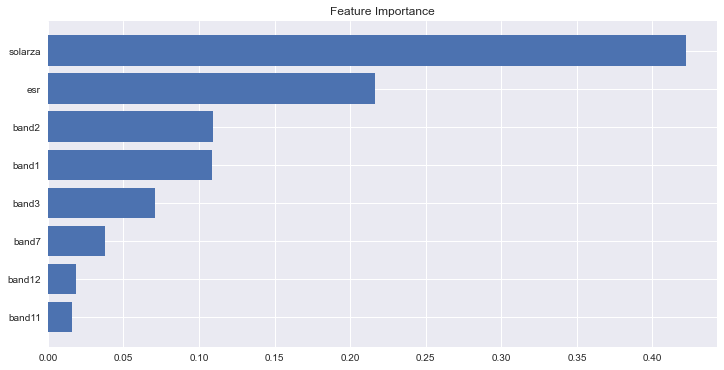

In [40]:
feature_importance = xgb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
plt.title('Feature Importance')

In [41]:
pred = xgb_model.predict(X_test)
pred

array([0.00120351, 0.00280866, 0.00211515, ..., 0.00212241, 0.00269064,
       0.00224026], dtype=float32)

In [48]:
pred = xgb_model.predict(X_test)
submission=pd.read_csv('1-1_검증데이터셋.csv', encoding='utf-8')
submission1=submission.copy()
submission1['UV'] = pred
submission1
submission1.to_csv("220224_xgb_uv_nooutlier_summer1_feature_importance.csv", index = False)

In [31]:
# X_test111.to_csv('202206_uv_final.csv', index=False)

In [101]:
# pd.read_csv('202206_uv_final.csv')

,yyyymmdd,hhnn,stn,lon,lat,band1,band2,band3,band4,band5,...,band12,band13,band14,band15,band16,solarza,sateza,esr,height,landtype
0,20220601,0,13,126.16000,33.30000,0.00000,0.00000,-0.00060,0.00060,-0.0003,...,241.07130,251.49092,250.11913,248.78686,243.12601,123.72706,38.96359,-5.16304,71.00,0
1,20220601,0,105,128.89098,37.75147,-0.00057,-0.00057,0.00000,-0.00030,0.0000,...,244.35010,262.71227,261.14580,257.52658,246.95577,119.74915,43.95463,-4.61100,26.04,3
2,20220601,0,108,126.96500,37.57100,0.00000,-0.00057,-0.00030,0.00045,0.0000,...,249.24111,271.81756,270.25616,266.99858,254.94651,119.65871,43.77999,-4.60329,85.50,3
3,20220601,0,112,126.62490,37.47772,0.00000,0.00000,0.00060,0.00045,-0.0003,...,249.94977,273.52547,272.33661,269.12853,256.15036,119.71313,43.67046,-4.61180,68.99,3
4,20220601,0,115,130.89864,37.48129,0.00000,0.00000,0.00089,-0.00030,0.0003,...,239.88321,253.29031,251.46606,249.01625,240.92761,120.21661,43.74521,-4.67107,222.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51850,20220625,0,146,127.11900,35.84080,0.00000,-0.00057,-0.00089,0.00015,0.0000,...,258.49191,286.87485,287.19605,285.48855,271.35400,119.84431,41.81018,-4.59718,62.90,3
51851,20220625,0,152,129.33472,35.58250,-0.00057,0.00000,-0.00030,-0.00030,-0.0003,...,263.99872,293.32422,293.51096,291.15861,274.60342,120.42121,41.52495,-4.67124,82.00,2
51852,20220625,0,156,126.89158,35.17294,0.00000,0.00000,0.00089,-0.00030,-0.0003,...,261.53112,290.14436,290.23278,288.05655,273.15633,120.46896,41.04849,-4.68457,72.38,3
51853,20220625,0,159,129.03203,35.10468,0.00000,0.00057,0.00030,-0.00075,-0.0003,...,260.95627,287.80066,287.63090,285.01340,270.36623,120.85844,40.96396,-4.73249,69.56,3


In [43]:
submission1

,YearMonthDayHourMinute,STN,UV
0,202206010000,13,0.001204
1,202206010000,105,0.002809
2,202206010000,108,0.002115
3,202206010000,112,0.001970
4,202206010000,115,0.002076
...,...,...,...
51850,202206250000,146,0.002300
51851,202206250000,152,0.003944
51852,202206250000,156,0.002122
51853,202206250000,159,0.002691


In [44]:
submission1['UV'].value_counts()      # 정렬해서 보기

0.002104    35
0.002121    35
0.002084    34
0.002067    32
0.002054    30
            ..
0.058904     1
0.141254     1
0.079161     1
0.058479     1
0.002240     1
Name: UV, Length: 46969, dtype: int64

<AxesSubplot:>

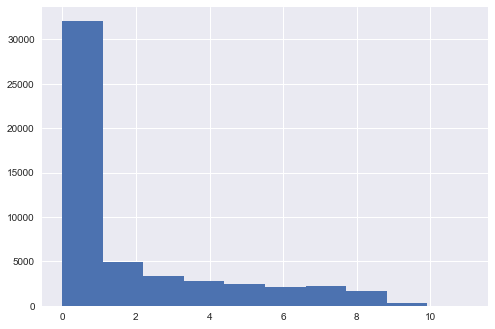

In [49]:
submission1['UV'].hist()      

In [46]:
submission1[submission1['UV']>7]

,YearMonthDayHourMinute,STN,UV
949,202206011030,115,7.113513
961,202206011040,105,7.067520
964,202206011040,115,7.504198
976,202206011050,105,7.037755
979,202206011050,115,7.578603
...,...,...,...
50999,202206241430,165,7.842011
51004,202206241440,115,7.127384
51007,202206241440,133,7.165480
51014,202206241440,165,7.119721


In [47]:
submission1[submission1['UV']<7]

,YearMonthDayHourMinute,STN,UV
0,202206010000,13,0.001204
1,202206010000,105,0.002809
2,202206010000,108,0.002115
3,202206010000,112,0.001970
4,202206010000,115,0.002076
...,...,...,...
51850,202206250000,146,0.002300
51851,202206250000,152,0.003944
51852,202206250000,156,0.002122
51853,202206250000,159,0.002691


In [ ]:
# 관측소별로 자외선 지수 분석할지.

<AxesSubplot:>

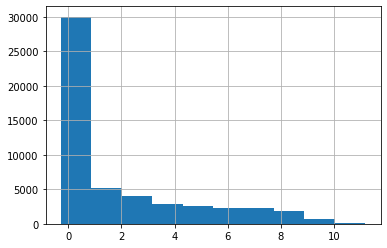

In [85]:
# pd.read_csv('220224.csv')['UV'].hist()

In [86]:
# pd.read_csv('220224.csv')

,YearMonthDayHourMinute,STN,UV
0,2.022060e+11,13,0.00471
1,2.022060e+11,105,0.00471
2,2.022060e+11,108,0.00471
3,2.022060e+11,112,0.00471
4,2.022060e+11,115,0.00471
...,...,...,...
51850,2.022060e+11,146,0.00471
51851,2.022060e+11,152,0.00471
51852,2.022060e+11,156,0.00471
51853,2.022060e+11,159,0.00471


# Model_by_corr

In [ ]:
X_train = train[['band1','band2','band3','band4','band6','band7','solarza','esr','band11','band12','band13','band14','band15','band16']]
X_val = val[['band1','band2','band3','band4','band6','band7','solarza','esr','band11','band12','band13','band14','band15','band16']]
X_test = test[['band1','band2','band3','band4','band6','band7','solarza','esr','band11','band12','band13','band14','band15','band16']]

In [ ]:
# submission1.to_csv("220224_xgb_uv_nooutlier_summer1_feature_corr.csv", index = False)

In [ ]:
# 이건 0.55정도 val_mse나옴

In [50]:
li = list(pd.read_csv('220224_xgb_uv_nooutlier_summer1_feature_corr.csv')['UV'].values)
li

li_0_1=[]
li_1_2=[]
li_2_3=[]
li_3_4=[]
li_4_5=[]
li_5_6=[]
li_6_7=[]
li_7_8=[]
li_8_9=[]
li_9_10=[]
li_10_11=[]
li_11_12=[]
li_12_13=[]
li_13_=[]
for i in range(len(li)):
    if (li[i]>=0 and li[i]<1):
        li_0_1.append(li[i])
    elif (li[i]>=1 and li[i]<2):
        li_1_2.append(li[i])
    elif (li[i]>=2 and li[i]<3):
        li_2_3.append(li[i])
    elif (li[i]>=3 and li[i]<4):
        li_3_4.append(li[i])
    elif (li[i]>=4 and li[i]<5):
        li_4_5.append(li[i])
    elif (li[i]>=5 and li[i]<6):
        li_5_6.append(li[i])
    elif (li[i]>=6 and li[i]<7):
        li_6_7.append(li[i])
    elif (li[i]>=7 and li[i]<8):
        li_7_8.append(li[i])
    elif (li[i]>=8 and li[i]<9):
        li_8_9.append(li[i])
    elif (li[i]>=9 and li[i]<10):
        li_9_10.append(li[i])
    elif (li[i]>=10 and li[i]<11):
        li_10_11.append(li[i])
    elif (li[i]>=11 and li[i]<12):
        li_11_12.append(li[i])
    elif (li[i]>=12 and li[i]<13):
        li_12_13.append(li[i])
    elif li[i]>=13:
        li_13_.append(li[i])

In [51]:
df11_num = pd.DataFrame([len(li_0_1),len(li_1_2),len(li_2_3),len(li_3_4),len(li_4_5),len(li_5_6),\
                        len(li_6_7),len(li_7_8),len(li_8_9),len(li_9_10),len(li_10_11),len(li_11_12),len(li_12_13),\
                        len(li_13_)])
df11_num

df11_ratio = pd.DataFrame([100*len(li_0_1)/len(li), 100*len(li_1_2)/len(li), 100*len(li_2_3)/len(li),\
                         100*len(li_3_4)/len(li), 100*len(li_4_5)/len(li), 100*len(li_5_6)/len(li), \
                          100*len(li_6_7)/len(li),100*len(li_7_8)/len(li),100*len(li_8_9)/len(li),100*len(li_9_10)/len(li),\
                          100*len(li_10_11)/len(li),100*len(li_11_12)/len(li),100*len(li_12_13)/len(li),\
                          100*len(li_13_)/len(li)])
df11_ratio

df11_corr = pd.concat([df11_num,df11_ratio],axis=1)
df11_corr.columns = ['corr_num','corr_ratio']
df11_corr.index = ['0_1','1_2','2_3','3_4','4_5','5_6','6_7','7_8','8_9','9_10','10_11','11_12','12_13','13_']
df11_corr

,corr_num,corr_ratio
0_1,30601,59.012631
1_2,4796,9.248867
2_3,3254,6.275190
3_4,2628,5.067978
4_5,2294,4.423874
5_6,2079,4.009257
6_7,1935,3.731559
7_8,1850,3.567641
8_9,1141,2.200366
9_10,272,0.524540


In [52]:
li = list(pd.read_csv('220224_xgb_uv_nooutlier_summer1_feature_importance.csv')['UV'].values)
li

li_0_1=[]
li_1_2=[]
li_2_3=[]
li_3_4=[]
li_4_5=[]
li_5_6=[]
li_6_7=[]
li_7_8=[]
li_8_9=[]
li_9_10=[]
li_10_11=[]
li_11_12=[]
li_12_13=[]
li_13_=[]
for i in range(len(li)):
    if (li[i]>=0 and li[i]<1):
        li_0_1.append(li[i])
    elif (li[i]>=1 and li[i]<2):
        li_1_2.append(li[i])
    elif (li[i]>=2 and li[i]<3):
        li_2_3.append(li[i])
    elif (li[i]>=3 and li[i]<4):
        li_3_4.append(li[i])
    elif (li[i]>=4 and li[i]<5):
        li_4_5.append(li[i])
    elif (li[i]>=5 and li[i]<6):
        li_5_6.append(li[i])
    elif (li[i]>=6 and li[i]<7):
        li_6_7.append(li[i])
    elif (li[i]>=7 and li[i]<8):
        li_7_8.append(li[i])
    elif (li[i]>=8 and li[i]<9):
        li_8_9.append(li[i])
    elif (li[i]>=9 and li[i]<10):
        li_9_10.append(li[i])
    elif (li[i]>=10 and li[i]<11):
        li_10_11.append(li[i])
    elif (li[i]>=11 and li[i]<12):
        li_11_12.append(li[i])
    elif (li[i]>=12 and li[i]<13):
        li_12_13.append(li[i])
    elif li[i]>=13:
        li_13_.append(li[i])

In [54]:
df11_num = pd.DataFrame([len(li_0_1),len(li_1_2),len(li_2_3),len(li_3_4),len(li_4_5),len(li_5_6),\
                        len(li_6_7),len(li_7_8),len(li_8_9),len(li_9_10),len(li_10_11),len(li_11_12),len(li_12_13),\
                        len(li_13_)])
df11_num

df11_ratio = pd.DataFrame([100*len(li_0_1)/len(li), 100*len(li_1_2)/len(li), 100*len(li_2_3)/len(li),\
                         100*len(li_3_4)/len(li), 100*len(li_4_5)/len(li), 100*len(li_5_6)/len(li), \
                          100*len(li_6_7)/len(li),100*len(li_7_8)/len(li),100*len(li_8_9)/len(li),100*len(li_9_10)/len(li),\
                          100*len(li_10_11)/len(li),100*len(li_11_12)/len(li),100*len(li_12_13)/len(li),\
                          100*len(li_13_)/len(li)])
df11_ratio

df11_im = pd.concat([df11_num,df11_ratio],axis=1)
df11_im.columns = ['im_num','im_ratio']
df11_im.index = ['0_1','1_2','2_3','3_4','4_5','5_6','6_7','7_8','8_9','9_10','10_11','11_12','12_13','13_']
df11_im

,im_num,im_ratio
0_1,31503,60.752097
1_2,4655,8.976955
2_3,3269,6.304117
3_4,2671,5.150902
4_5,2296,4.427731
5_6,2087,4.024684
6_7,1933,3.727702
7_8,1989,3.835696
8_9,1199,2.312217
9_10,192,0.370263


In [55]:
li = list(pd.read_csv('220224_xgb_uv_nooutlier_summer1.csv')['UV'].values)
li

li_0_1=[]
li_1_2=[]
li_2_3=[]
li_3_4=[]
li_4_5=[]
li_5_6=[]
li_6_7=[]
li_7_8=[]
li_8_9=[]
li_9_10=[]
li_10_11=[]
li_11_12=[]
li_12_13=[]
li_13_=[]
for i in range(len(li)):
    if (li[i]>=0 and li[i]<1):
        li_0_1.append(li[i])
    elif (li[i]>=1 and li[i]<2):
        li_1_2.append(li[i])
    elif (li[i]>=2 and li[i]<3):
        li_2_3.append(li[i])
    elif (li[i]>=3 and li[i]<4):
        li_3_4.append(li[i])
    elif (li[i]>=4 and li[i]<5):
        li_4_5.append(li[i])
    elif (li[i]>=5 and li[i]<6):
        li_5_6.append(li[i])
    elif (li[i]>=6 and li[i]<7):
        li_6_7.append(li[i])
    elif (li[i]>=7 and li[i]<8):
        li_7_8.append(li[i])
    elif (li[i]>=8 and li[i]<9):
        li_8_9.append(li[i])
    elif (li[i]>=9 and li[i]<10):
        li_9_10.append(li[i])
    elif (li[i]>=10 and li[i]<11):
        li_10_11.append(li[i])
    elif (li[i]>=11 and li[i]<12):
        li_11_12.append(li[i])
    elif (li[i]>=12 and li[i]<13):
        li_12_13.append(li[i])
    elif li[i]>=13:
        li_13_.append(li[i])

In [56]:
df11_num = pd.DataFrame([len(li_0_1),len(li_1_2),len(li_2_3),len(li_3_4),len(li_4_5),len(li_5_6),\
                        len(li_6_7),len(li_7_8),len(li_8_9),len(li_9_10),len(li_10_11),len(li_11_12),len(li_12_13),\
                        len(li_13_)])
df11_num

df11_ratio = pd.DataFrame([100*len(li_0_1)/len(li), 100*len(li_1_2)/len(li), 100*len(li_2_3)/len(li),\
                         100*len(li_3_4)/len(li), 100*len(li_4_5)/len(li), 100*len(li_5_6)/len(li), \
                          100*len(li_6_7)/len(li),100*len(li_7_8)/len(li),100*len(li_8_9)/len(li),100*len(li_9_10)/len(li),\
                          100*len(li_10_11)/len(li),100*len(li_11_12)/len(li),100*len(li_12_13)/len(li),\
                          100*len(li_13_)/len(li)])
df11_ratio

df11_or = pd.concat([df11_num,df11_ratio],axis=1)
df11_or.columns = ['or_num','or_ratio']
df11_or.index = ['0_1','1_2','2_3','3_4','4_5','5_6','6_7','7_8','8_9','9_10','10_11','11_12','12_13','13_']
df11_or

,or_num,or_ratio
0_1,31162,60.094494
1_2,4164,8.030084
2_3,3614,6.969434
3_4,2792,5.384245
4_5,2430,4.686144
5_6,2264,4.366021
6_7,2009,3.874265
7_8,1704,3.286086
8_9,1325,2.555202
9_10,374,0.721242


In [59]:
dff = pd.concat([df11_or,df11_im, df11_corr], axis=1)

In [60]:
dff

,or_num,or_ratio,im_num,im_ratio,corr_num,corr_ratio
0_1,31162,60.094494,31503,60.752097,30601,59.012631
1_2,4164,8.030084,4655,8.976955,4796,9.248867
2_3,3614,6.969434,3269,6.304117,3254,6.275190
3_4,2792,5.384245,2671,5.150902,2628,5.067978
4_5,2430,4.686144,2296,4.427731,2294,4.423874
5_6,2264,4.366021,2087,4.024684,2079,4.009257
6_7,2009,3.874265,1933,3.727702,1935,3.731559
7_8,1704,3.286086,1989,3.835696,1850,3.567641
8_9,1325,2.555202,1199,2.312217,1141,2.200366
9_10,374,0.721242,192,0.370263,272,0.524540
